## Objective
Plot model's performance as a function of stride of sliding window

In [28]:
# %load_ext autoreload
# %autoreload

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
from src.model import ModelSpikeSorter
from src.data import RecordingCrossVal
from src.utils import random_seed
from src.plot import set_dpi
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Load model
MODEL_PATH = "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954/230101_134042_729459"
##
model = ModelSpikeSorter.load(MODEL_PATH)

front_buffer = model.buffer_front_sample + model.num_output_locs - 1  # The earliest a spike can appear is last output location of first window (-1 since inclusive,exclusive)
# Update model based on new larger samples
model.loc_first_frame = front_buffer

In [19]:
# Load dataloader
VAL_REC = "2954"  # Should be the val rec that model was trained on
##
# Spikes can occur within a model.num_output_locs region of the sample. This extra math is for getting windows that do not perfectly overlap with this region
rec_sample_size = 3 * model.num_output_locs - 2 + model.buffer_front_sample + model.buffer_end_sample  # Max dist. between beginning of first window and end of last window
end_buffer = model.buffer_end_sample + model.num_output_locs - 1  # The latest a spike can appear is first output location of last window (-1 since there are num_output_locs-1 frames after first output location)
rec_cross_val = RecordingCrossVal(sample_size=rec_sample_size, front_buffer=front_buffer, end_buffer=end_buffer,
                                  num_wfs_probs=[0.6, 0.24, 0.12, 0.04], isi_wf_min=5, isi_wf_max=None,
                                  samples_per_waveform=(20, 40),
                                  thresh_amp=3, thresh_std=0.6,
                                  mmap_mode="r", device="cuda",
                                  as_datasets=True)
_, train, val = rec_cross_val[VAL_REC]

In [ ]:
# Exact sample size rec_cross_val needs to return based on num_output_locs and stride
# start = -num_output_locs + stride
# i = (num_output_locs - 1) if (num_output_locs - start) % stride == 0 else start + (num_output_locs - start) // stride * stride  # for i in range(start, num_output_locs, stride):
# end = num_output_locs + i
# size = end - start

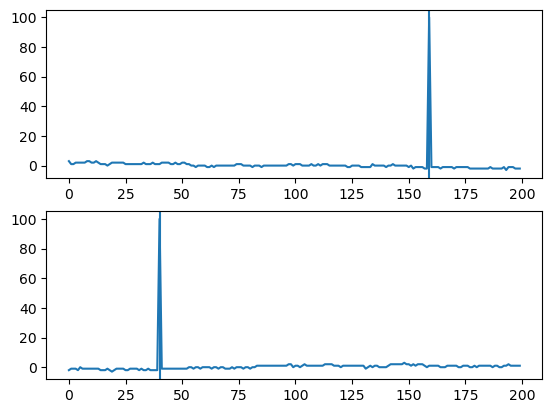

In [4]:
# Sanity check that front_buffer and end_buffer are correct --> Vertical line and spike should align
trace, _, _, _ = val[0]  # Get sample
trace = trace[0, :].cpu()
trace[front_buffer] = 100  # Set last output location of first window to spike
trace[-end_buffer-1] = 100  # Set first output location of last window to spike
fig, (a0, a1) = plt.subplots(2)
a0.plot(trace[:model.sample_size])  # Plot first window
a0.axvline(model.buffer_front_sample + model.num_output_locs-1)  # Last output location frame
a1.plot(trace[-model.sample_size:])  # Plot last window
a1.axvline(model.buffer_front_sample)  # First output location frame
plt.show()

In [8]:
# Sanity check that getting windows work --> trace and window should overlap perfectly
# plt.plot(trace[0, -200:], label="trace")
# plt.plot(windows[-1, 0, :], label="window")
# plt.legend()
# plt.show()

In [87]:
def get_model_outputs(trace, stride):
    """
    Get models outputs when summing and maxing overlapping regions in the input trace

    :return: tuple
        Model's outputs
        0) When overlapping regions of model's outputs are summed
        1) When max value of at each frame in model's output is included
    """
    assert stride <= model.num_output_locs, "'stride' is greater than 'model.num_output_locs' so frames will be skipped in trace"

    window_start = stride-1  # First frame of first window in trace

    # Get the sliding windows of the input trace
    windows = [trace[:, i:i+model.sample_size] for i in range(window_start, rec_sample_size-model.sample_size+1, stride)]
    windows = torch.stack(windows, dim=0)

    # Get model's outputs
    with torch.no_grad():
        outputs = model(windows).cpu()

    # Overlap model's outputs
    num_outputs, output_size = outputs.shape
    outputs_summed = torch.zeros((output_size,), dtype=torch.float32, device="cpu")
    outputs_maxed = torch.full((output_size,), -torch.inf, dtype=torch.float32, device="cpu")
    outputs_overlap_count = torch.zeros((output_size,), dtype=torch.int, device="cpu")  # For calculating averaged outputs
    for i in range(num_outputs):
        output_start_frame = (window_start + i * stride) + model.buffer_front_sample  # Position of first frame in output relative to entire sample

        set_dpi(50)
        plt.plot(outputs[i])
        plt.show()

        if output_start_frame <= front_buffer:
            # Get overlapping region
            start = front_buffer - output_start_frame
            output_overlap = outputs[i, start:]  # Region of output that overlaps with outputs_summed

            # Sum outputs
            outputs_summed[:len(output_overlap)] += output_overlap

            # Max outputs
            overlap_stacked = torch.vstack([outputs_maxed[:len(output_overlap)], output_overlap])
            outputs_maxed[:len(output_overlap)] = torch.max(overlap_stacked, dim=0)[0]

            # Count number of overlaps
            outputs_overlap_count[:len(output_overlap)] += 1
        else:
            # Get overlapping region
            end = front_buffer + output_size - output_start_frame
            output_overlap = outputs[i, :end]  # Region of output that overlaps with outputs_summed

            # Sum outputs
            outputs_summed[-len(output_overlap):] += output_overlap

            # Max outputs
            overlap_stacked = torch.vstack([outputs_maxed[-len(output_overlap):], output_overlap])
            outputs_maxed[-len(output_overlap):] = torch.max(overlap_stacked, dim=0)[0]

            # Count number of overlaps
            outputs_overlap_count[-len(output_overlap):] += 1

    outputs_avged = outputs_summed / outputs_overlap_count

    return outputs_summed, outputs_maxed, outputs_avged

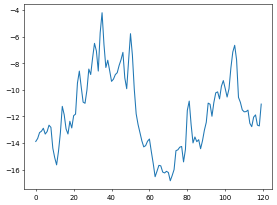

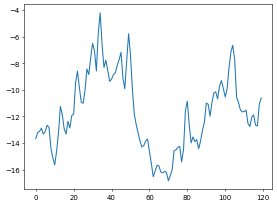

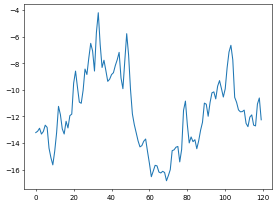

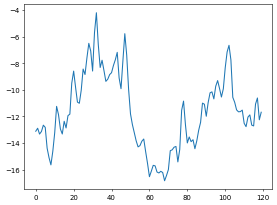

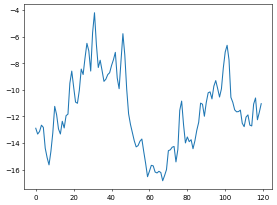

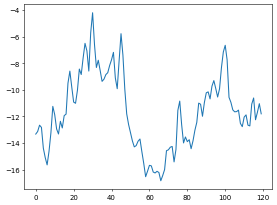

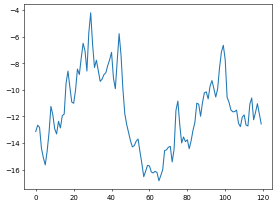

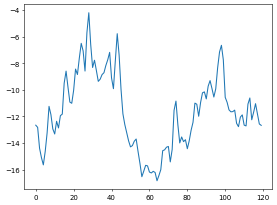

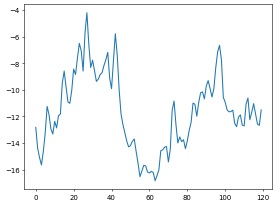

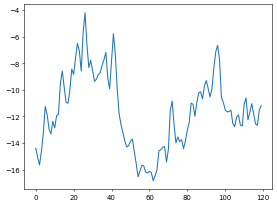

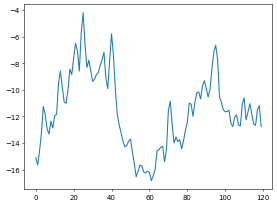

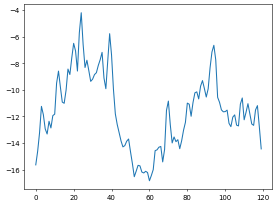

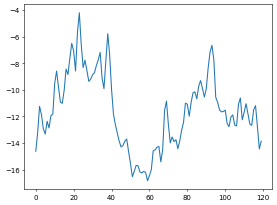

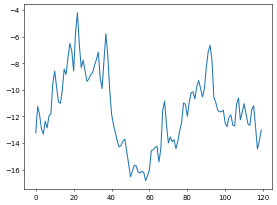

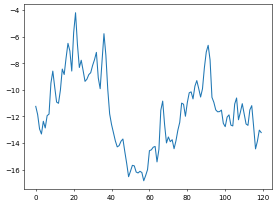

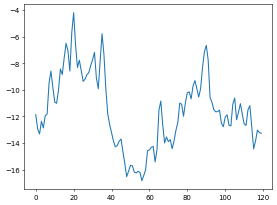

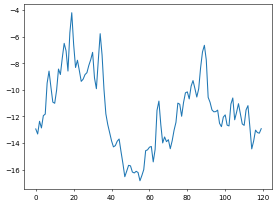

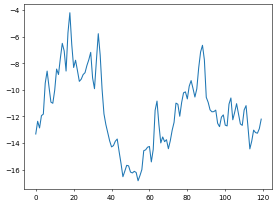

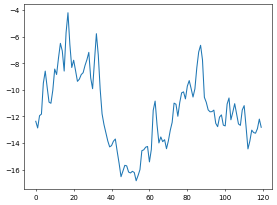

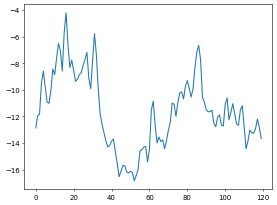

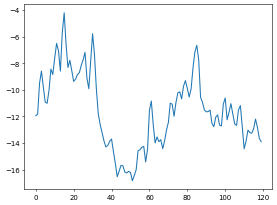

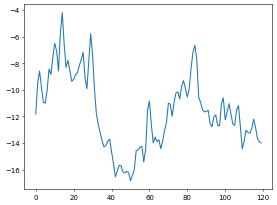

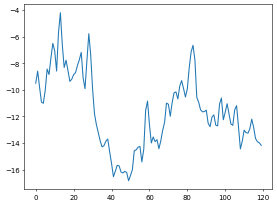

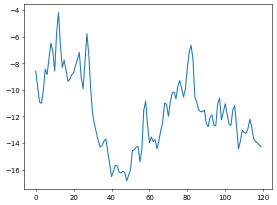

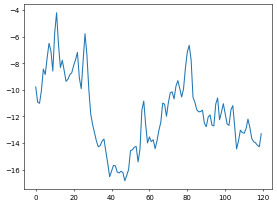

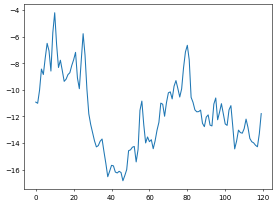

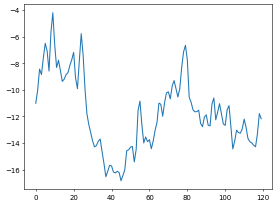

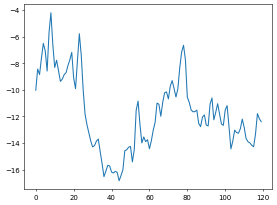

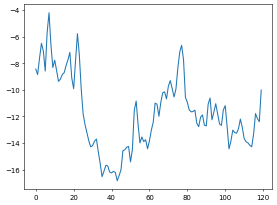

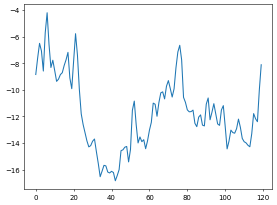

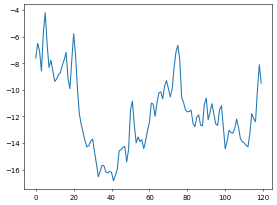

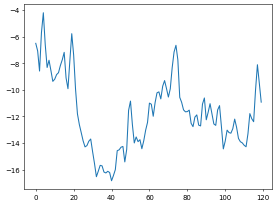

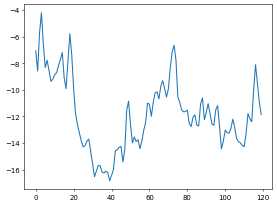

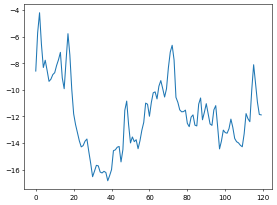

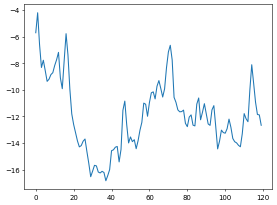

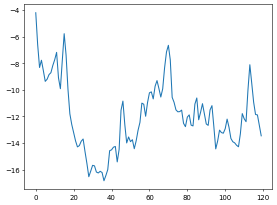

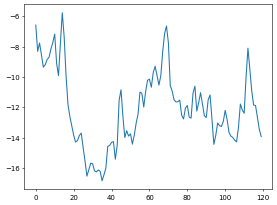

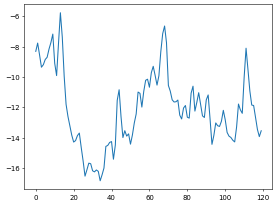

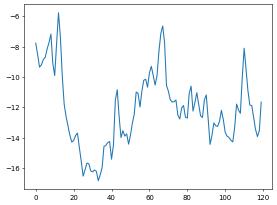

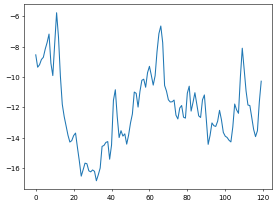

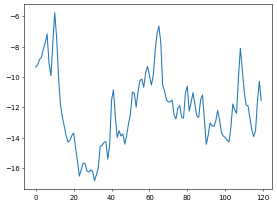

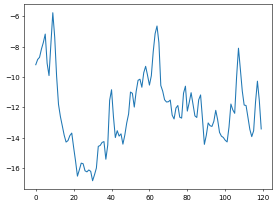

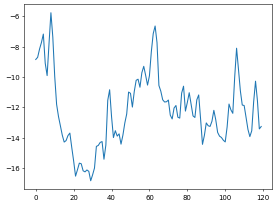

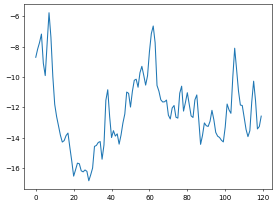

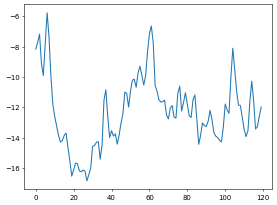

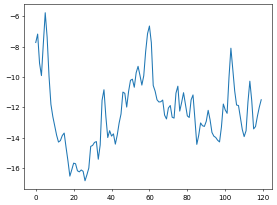

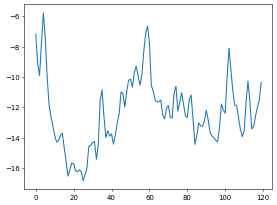

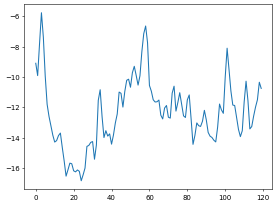

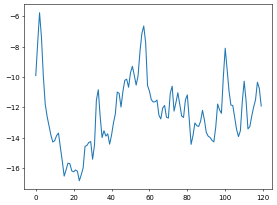

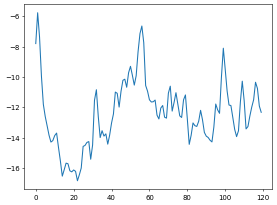

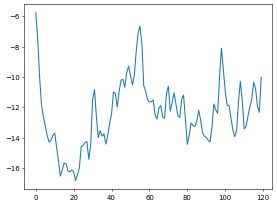

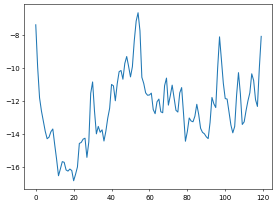

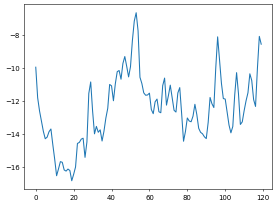

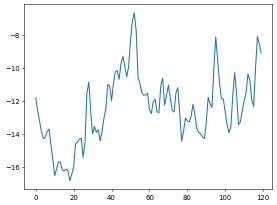

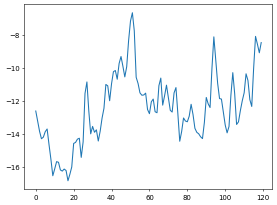

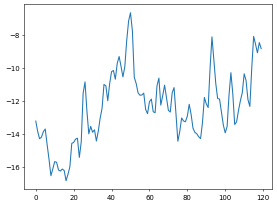

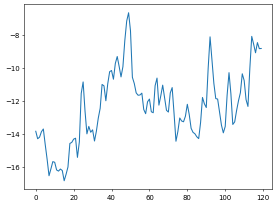

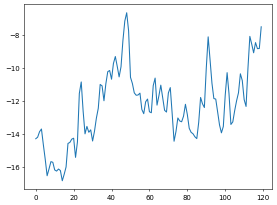

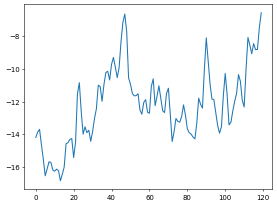

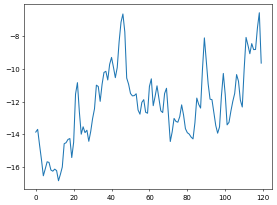

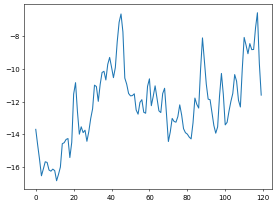

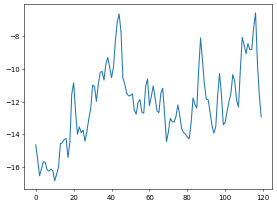

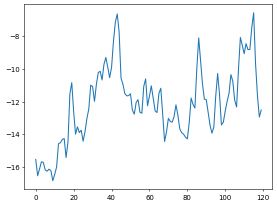

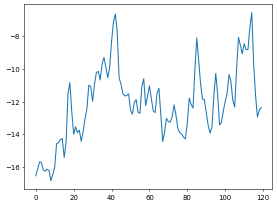

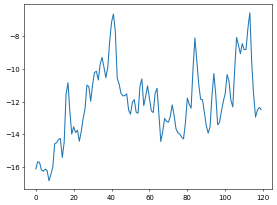

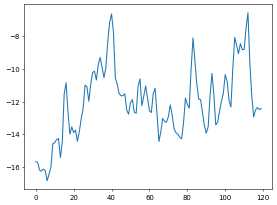

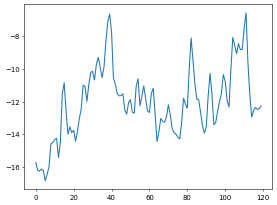

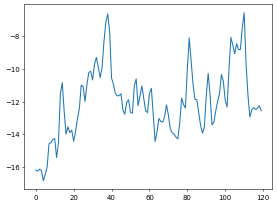

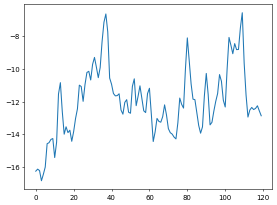

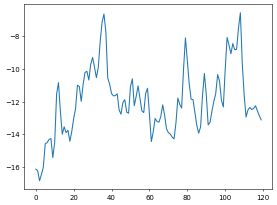

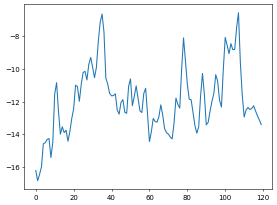

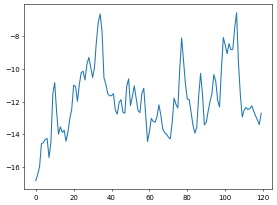

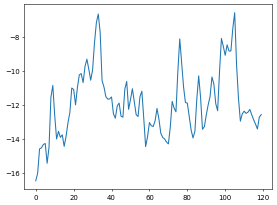

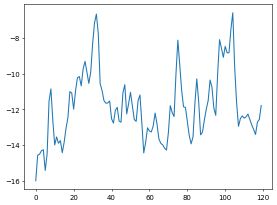

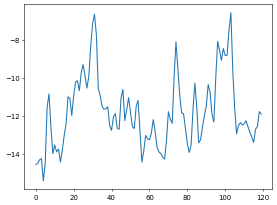

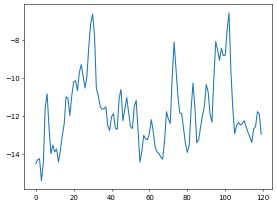

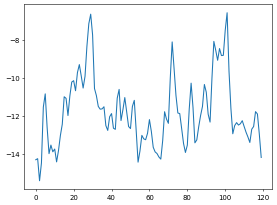

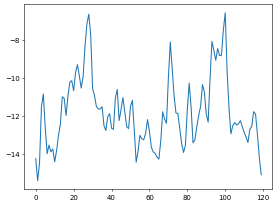

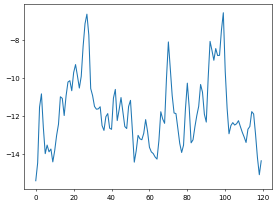

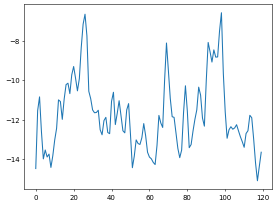

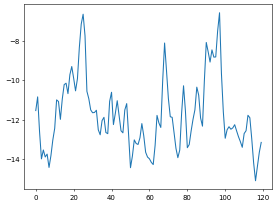

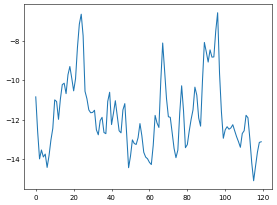

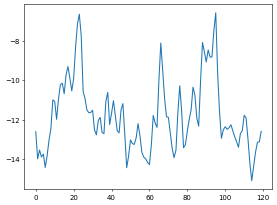

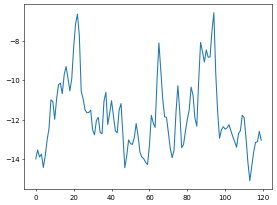

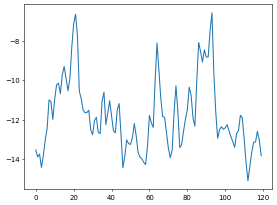

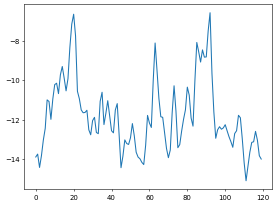

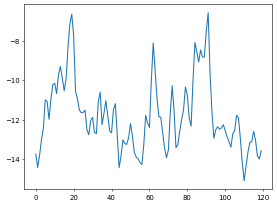

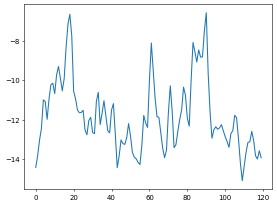

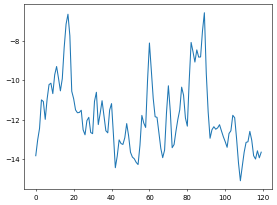

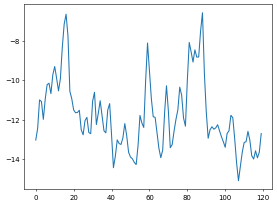

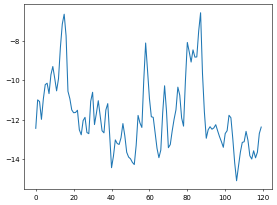

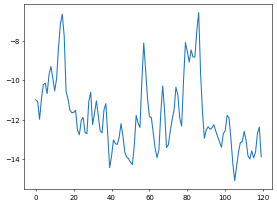

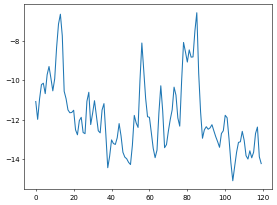

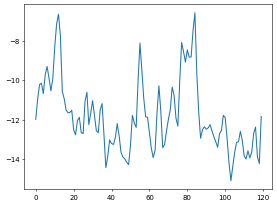

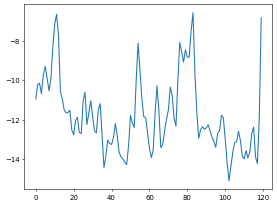

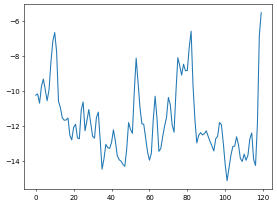

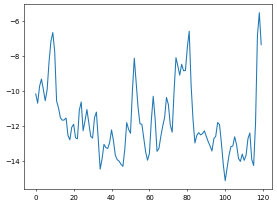

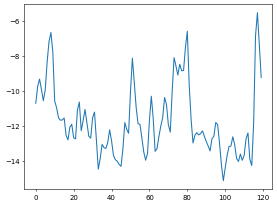

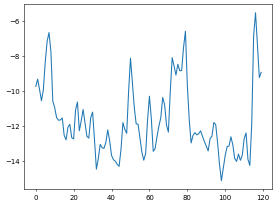

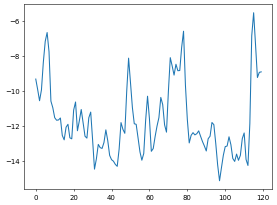

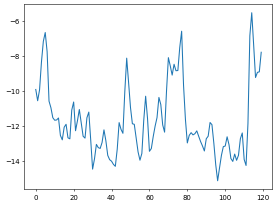

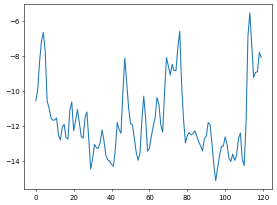

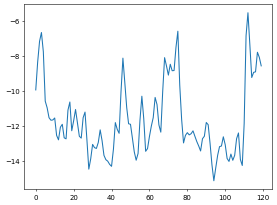

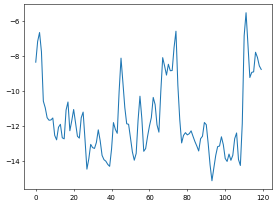

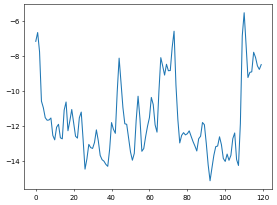

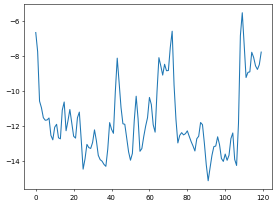

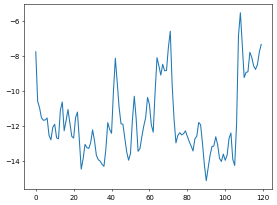

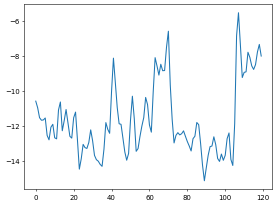

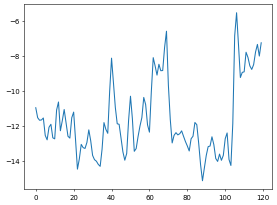

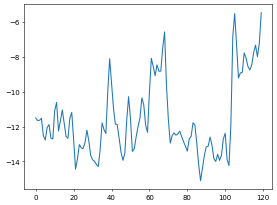

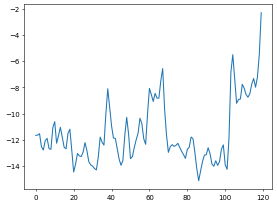

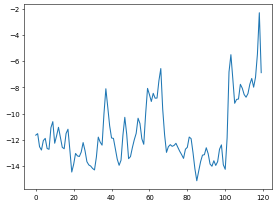

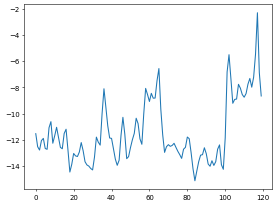

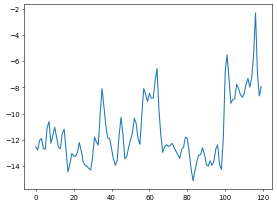

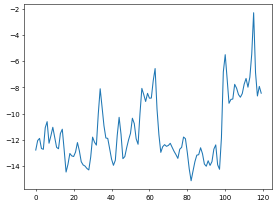

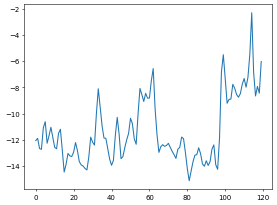

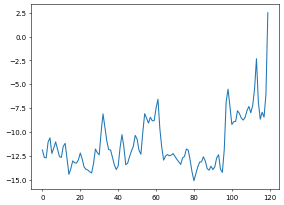

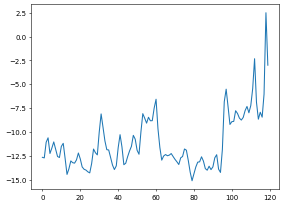

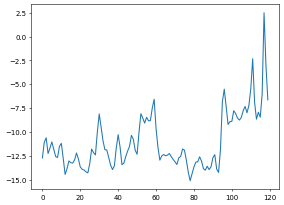

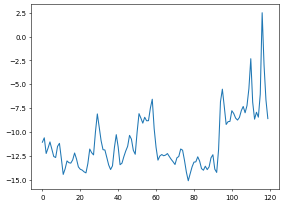

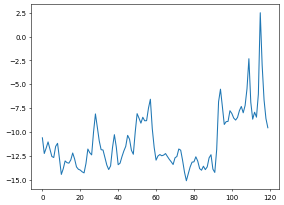

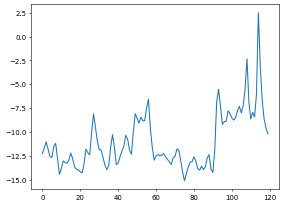

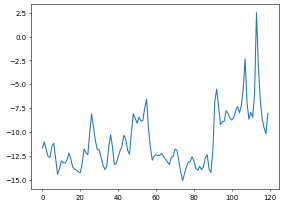

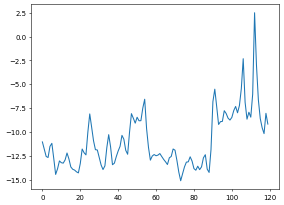

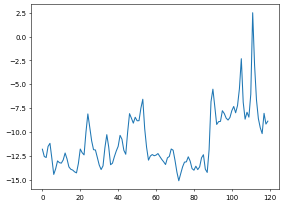

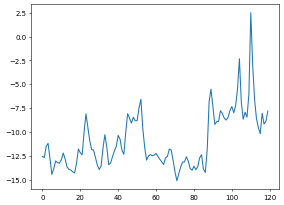

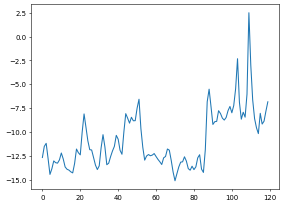

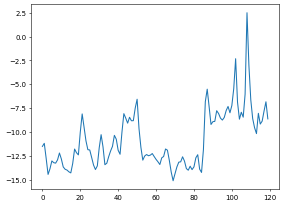

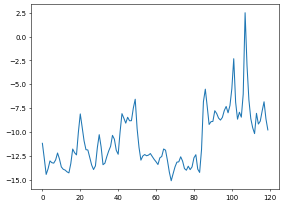

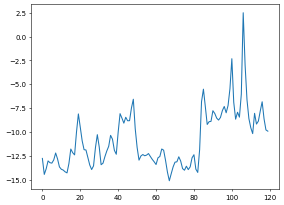

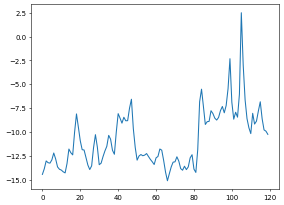

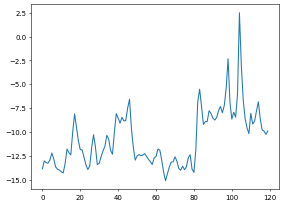

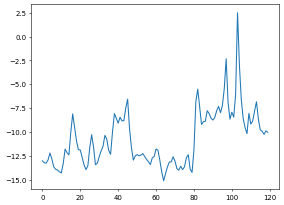

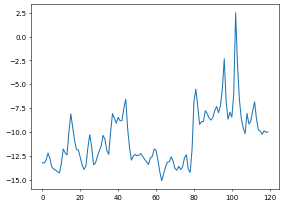

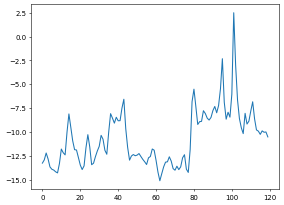

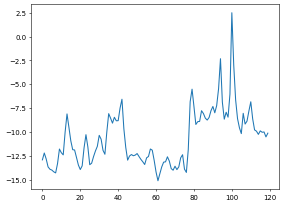

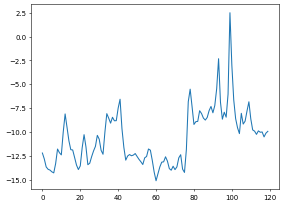

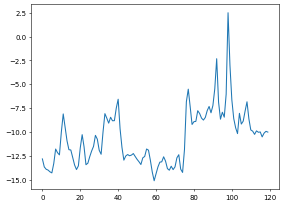

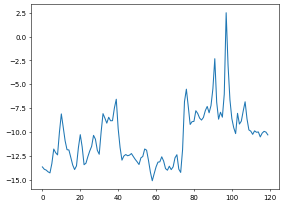

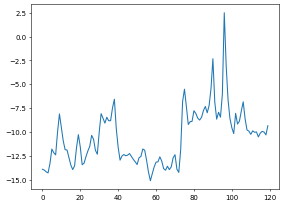

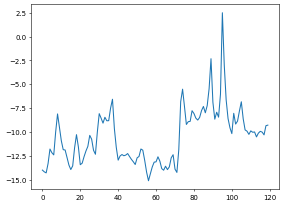

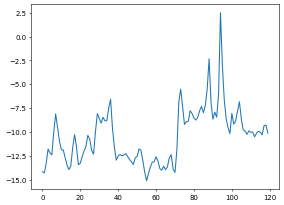

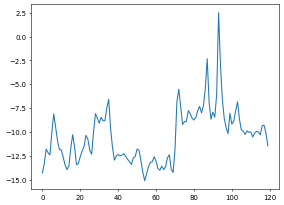

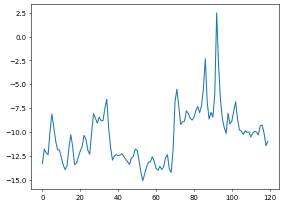

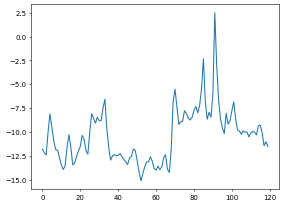

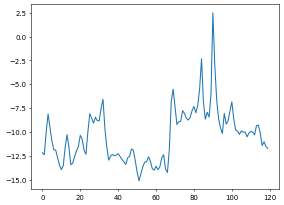

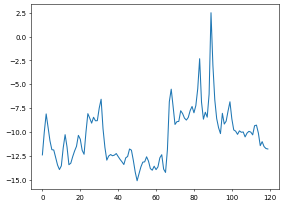

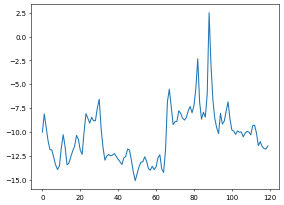

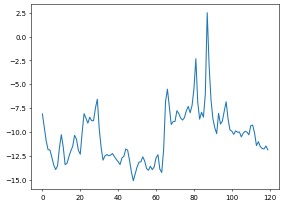

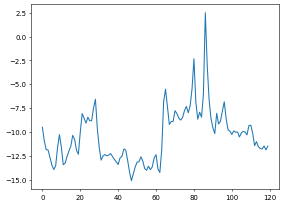

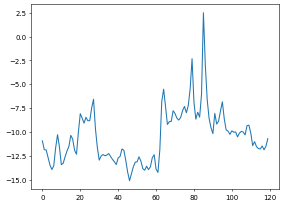

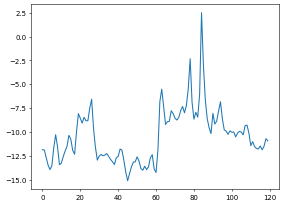

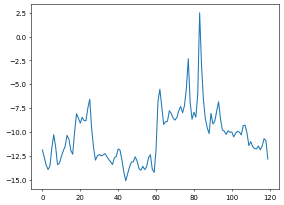

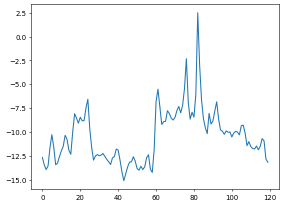

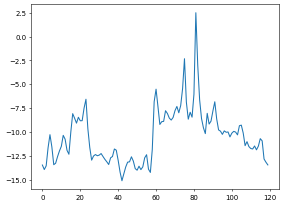

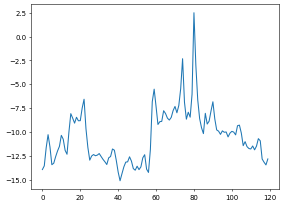

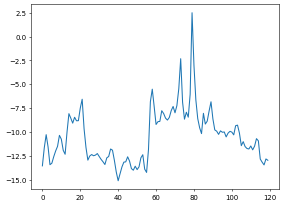

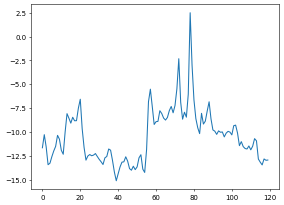

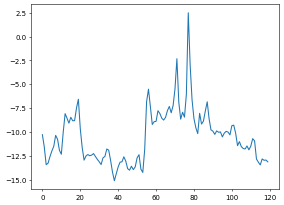

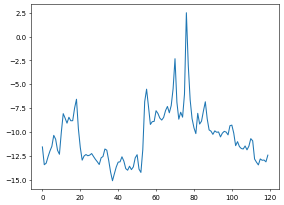

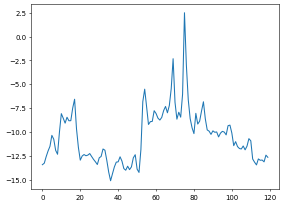

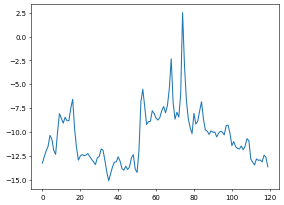

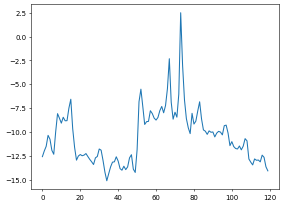

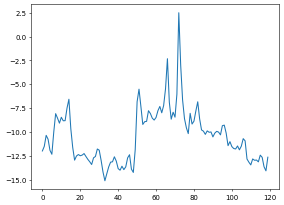

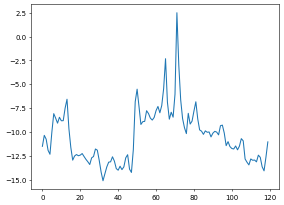

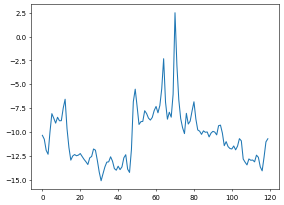

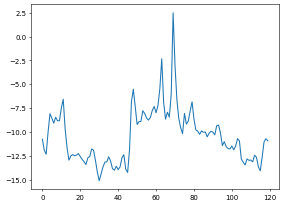

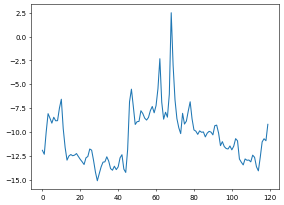

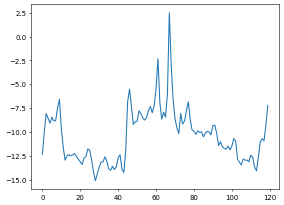

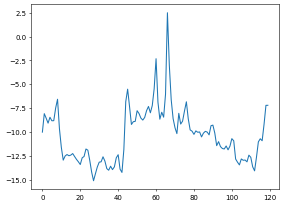

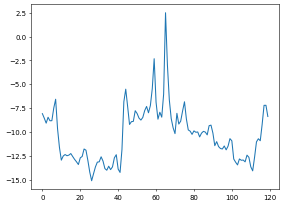

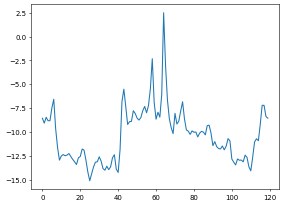

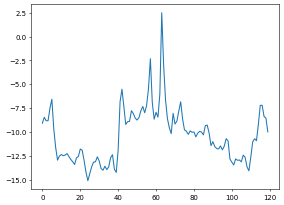

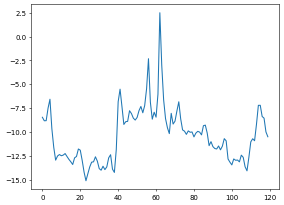

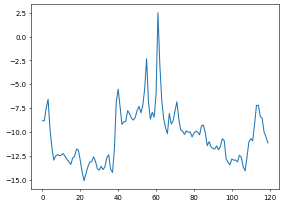

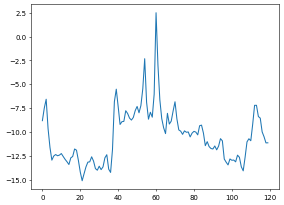

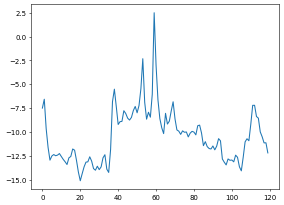

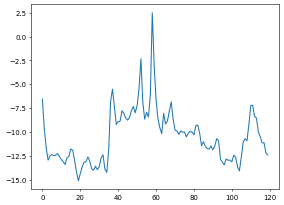

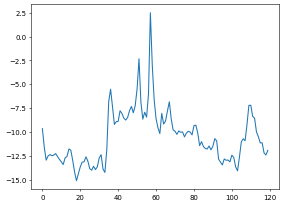

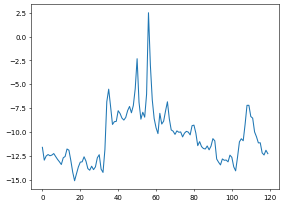

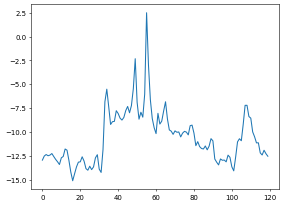

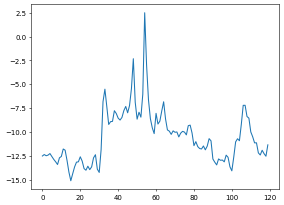

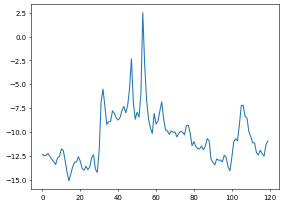

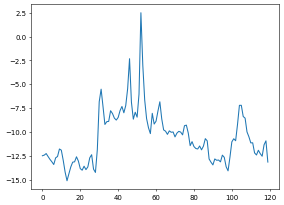

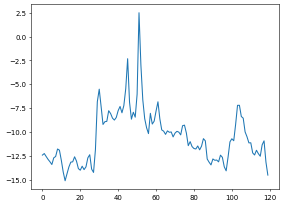

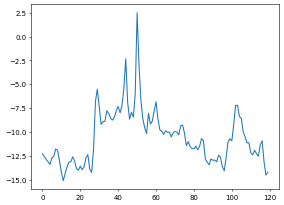

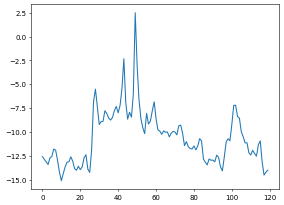

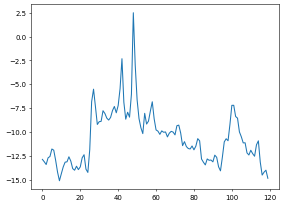

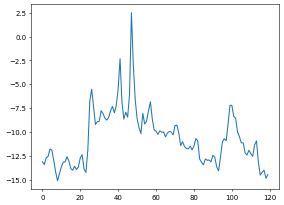

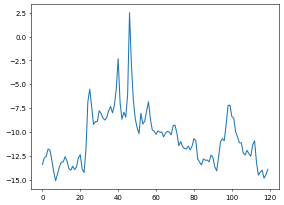

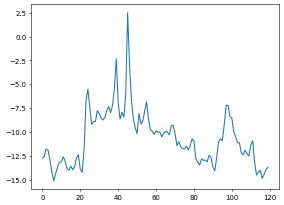

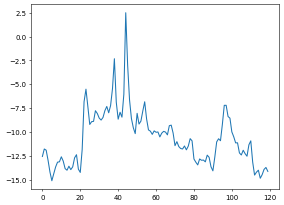

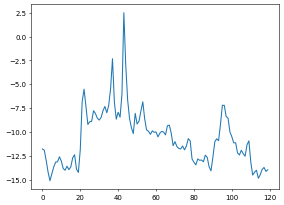

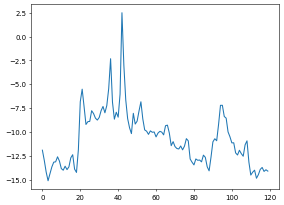

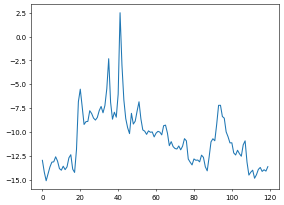

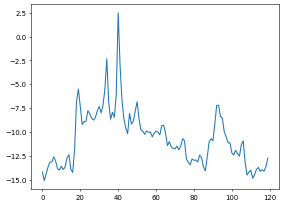

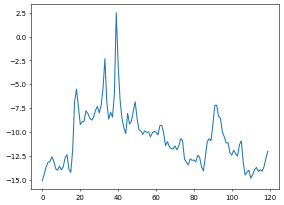

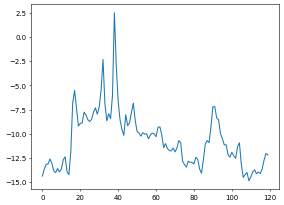

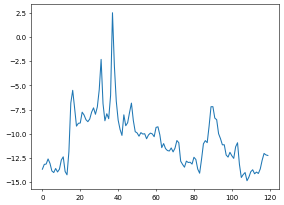

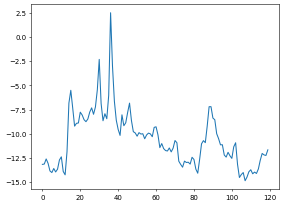

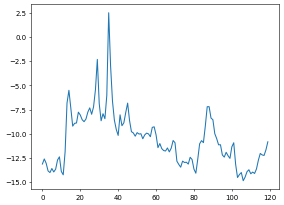

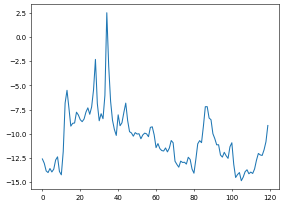

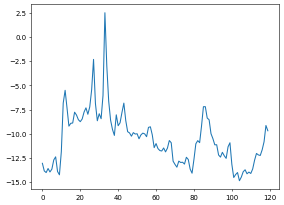

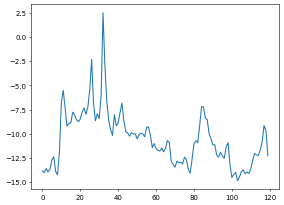

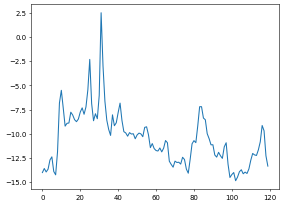

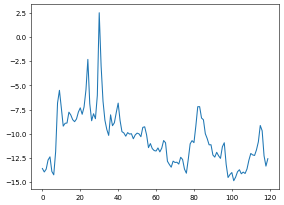

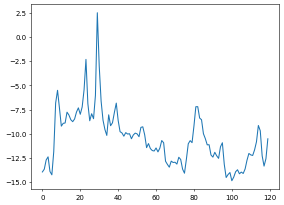

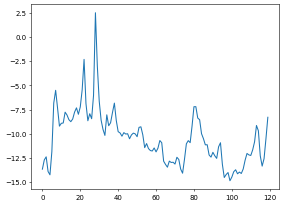

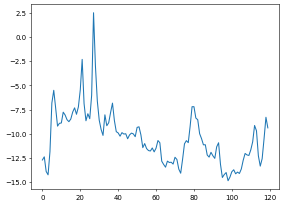

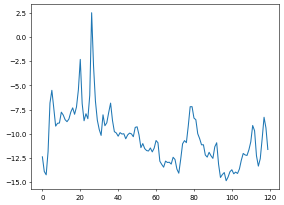

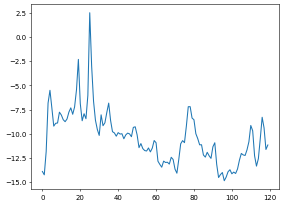

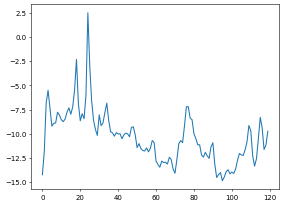

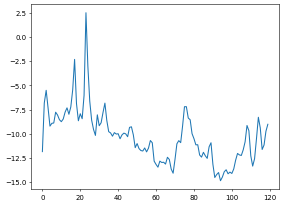

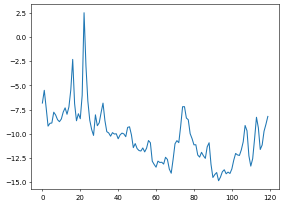

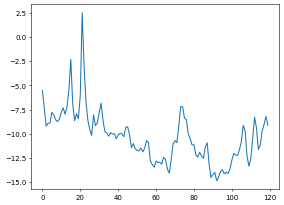

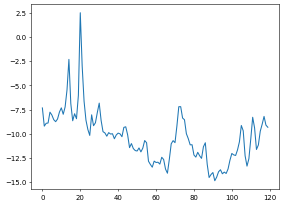

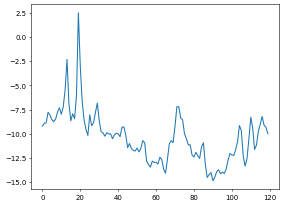

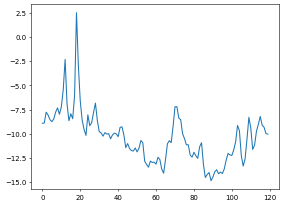

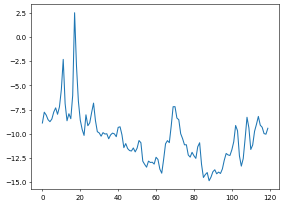

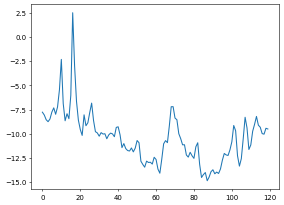

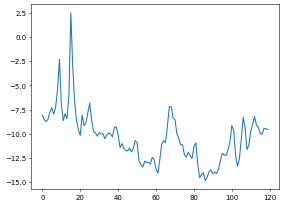

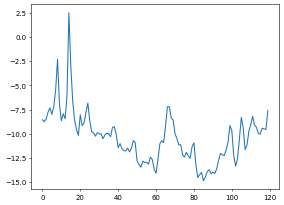

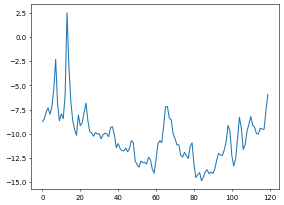

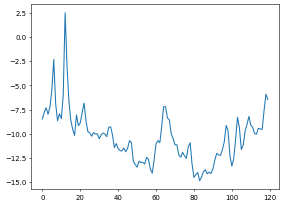

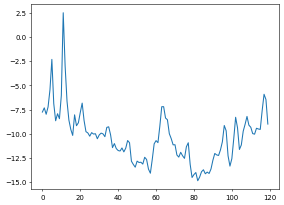

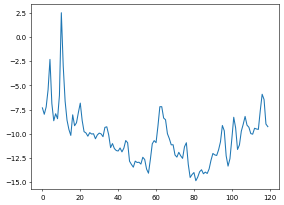

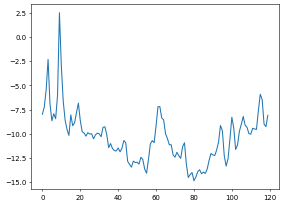

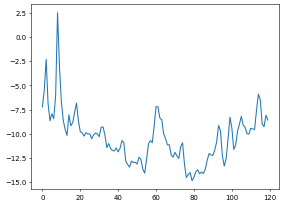

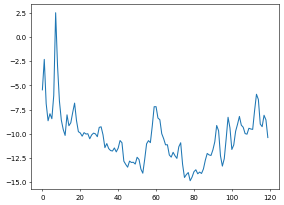

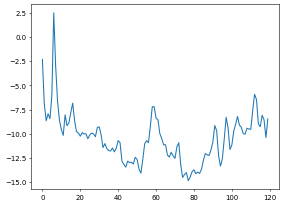

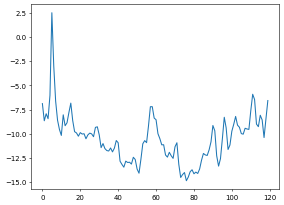

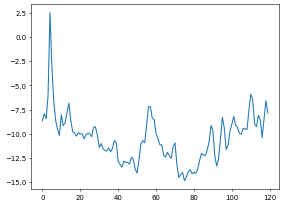

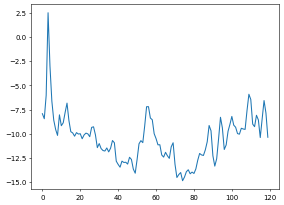

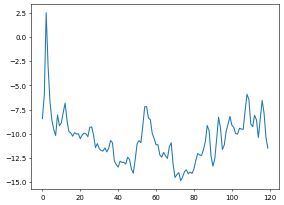

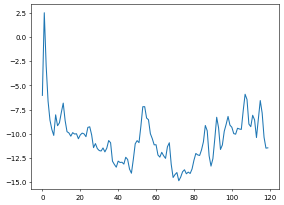

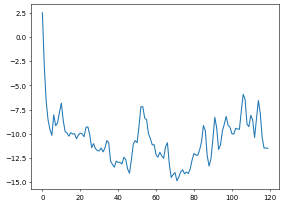

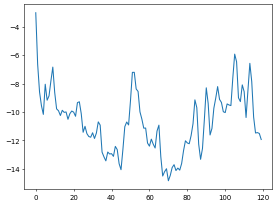

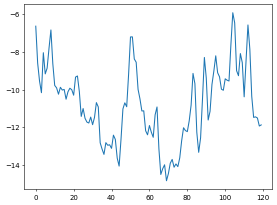

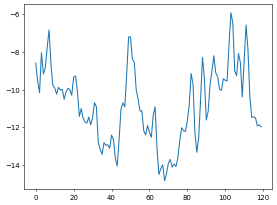

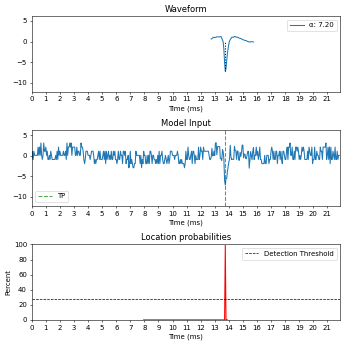

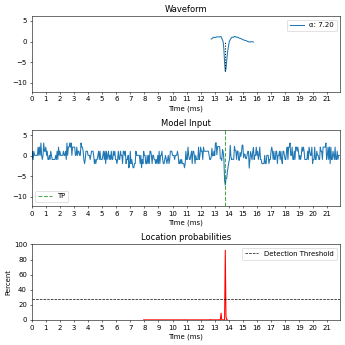

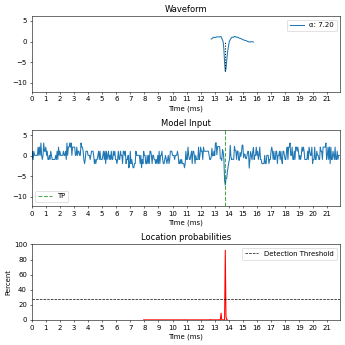

In [89]:
set_dpi(25)
# Sanity check that get_model_outputs works --> plots should show that model predicts well
trace, num_wfs, wf_locs, wf_alphas = val[val.samples_per_waveform//2 + 2]  # Get a sample where there is a waveform
outputs_summed, outputs_maxed, outputs_avged = get_model_outputs(trace, stride=1)

# Summed outputs
pred = model.outputs_to_preds(outputs_summed[None, :])[0]
model.plot_pred(trace[0], outputs_summed, pred, num_wfs, wf_locs, wf_alphas, val.get_alpha_to_waveform_dict())

# Maxed outputs
pred = model.outputs_to_preds(outputs_maxed[None, :])[0]
model.plot_pred(trace[0], outputs_maxed, pred, num_wfs, wf_locs, wf_alphas, val.get_alpha_to_waveform_dict())

# Averaged outputs
pred = model.outputs_to_preds(outputs_avged[None, :])[0]
model.plot_pred(trace[0], outputs_avged, pred, num_wfs, wf_locs, wf_alphas, val.get_alpha_to_waveform_dict())

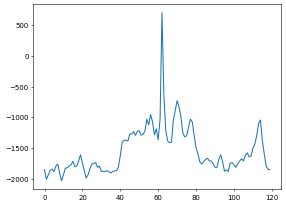

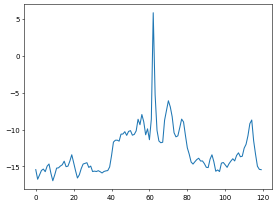

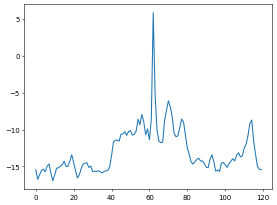

In [57]:
# Plot summed, maxed, and averaged outputs before sigmoid as sanity check
##
# Summed outputs
plt.plot(outputs_summed)
plt.show()
# Maxed outputs
plt.plot(outputs_maxed)
plt.show()
# Averaged outputs
plt.plot(outputs_avged)
plt.show()

In [55]:
print(torch.isclose(outputs_maxed, outputs_avged))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])


In [64]:
def get_inputs_outputs_lists(dataset, stride):
    """
    Get the inputs_list and outputs_list that result from feeding entire dataset through model
    These lists can be used for model.perf

    :param dataset: Either train or val (defined in beginning of notebook)
    :param stride: int
        Stride for windows

    :return: tuple
        0) inputs_list: inputs fed into model
        1) outputs_summed_list: summed windows
        2) outputs_maxed_list: maxed windows
    """

    assert dataset == train or dataset == val, "'dataset' must be 'train' or 'val'"

    inputs_list = []
    outputs_summed_list = []
    outputs_maxed_list = []
    outputs_avged_list = []
    for i in range(len(train)):
        trace, num_wfs, wf_locs, wf_alphas = train[i]
        outputs_summed, outputs_maxed, outputs_avged = get_model_outputs(trace, stride=stride)

        inputs_list.append((trace[None, :, :], torch.atleast_1d(num_wfs), wf_locs[None, :], wf_alphas[None, :]))
        outputs_summed_list.append(outputs_summed[None, :])
        outputs_maxed_list.append(outputs_maxed[None, :])
        outputs_avged_list.append(outputs_avged[None, :])

    return inputs_list, outputs_summed_list, outputs_maxed_list, outputs_avged_list


In [65]:
def tune_loc_prob_thresh(stride):
    """
    Find loc_prob_thresh for model that gives best f1 score based on window stride

    :param stride: int
    :return: tuple
        0) float: best thresh for summed windows
        1) float: best thresh for maxed windows
        2) float: best thresh for averaged windows
    """
    loc_prob_thresh_og = model.get_loc_prob_thresh()

    inputs_list, outputs_summed_list, outputs_maxed_list, outputs_avged_list = get_inputs_outputs_lists(train, stride)

    model.tune_loc_prob_thresh(inputs_list, outputs_list=outputs_summed_list, stop=100, verbose=False)
    thresh_summed = model.get_loc_prob_thresh()

    model.tune_loc_prob_thresh(inputs_list, outputs_list=outputs_maxed_list, stop=100, verbose=False)
    thresh_maxed = model.get_loc_prob_thresh()

    model.tune_loc_prob_thresh(inputs_list, outputs_list=outputs_avged_list, stop=100, verbose=False)
    thresh_avged = model.get_loc_prob_thresh()

    model.set_loc_prob_thresh(loc_prob_thresh_og)

    return thresh_summed, thresh_maxed, thresh_avged

In [66]:
# Get recall, precision, and f1 score based on stride
STRIDES = [1, 2, 5, 10, 20, 40, 60, 80, 100, 110, 120]  # Strides to evaluate performance on
TUNE_THRESH = True  # Whether to retune loc_prob_thresh based on sliding window
random_seed(201)
##
# {stride: (recall, precision, f1 score)}
stride_to_perf_summed = {}  # For summed windows
stride_to_perf_maxed = {}
stride_to_perf_avged = {}
for stride in STRIDES:
    assert stride <= model.num_output_locs, "a stride in 'STRIDES' is greater than model.num_output_locs, so frames in input trace will be skipped"

    if TUNE_THRESH:
        thresh_summed, thresh_maxed, thresh_avged = tune_loc_prob_thresh(stride)
    inputs_list, outputs_summed_list, outputs_maxed_list, outputs_avged_list = get_inputs_outputs_lists(val, stride)

    if TUNE_THRESH:
        model.set_loc_prob_thresh(thresh_summed)
    perf = model.perf(inputs_list, outputs_list=outputs_summed_list)
    model.perf_report(f"Summed {stride}", perf)
    stride_to_perf_summed[stride] = perf[3], perf[4], perf[5]

    if TUNE_THRESH:
        model.set_loc_prob_thresh(thresh_maxed)
    perf = model.perf(inputs_list, outputs_list=outputs_maxed_list)
    model.perf_report(f"Maxed {stride}", perf)
    stride_to_perf_maxed[stride] = perf[3], perf[4], perf[5]

    if TUNE_THRESH:
        model.set_loc_prob_thresh(thresh_avged)
    perf = model.perf(inputs_list, outputs_list=outputs_avged_list)
    model.perf_report(f"Avged {stride}", perf)
    stride_to_perf_avged[stride] = perf[3], perf[4], perf[5]

    print()


Using random seed 201
Summed 1: Loss: 61.819 | WF Detected: 85.3% | Accuracy: 99.9% | Recall: 82.7% | Precision: 97.0% | F1 Score: 89.3% | Loc MAD: 0.24 frames = 0.0120 ms
Maxed 1: Loss: 0.893 | WF Detected: 98.4% | Accuracy: 99.9% | Recall: 90.9% | Precision: 92.4% | F1 Score: 91.7% | Loc MAD: 0.23 frames = 0.0117 ms
Avged 1: Loss: 0.893 | WF Detected: 98.4% | Accuracy: 99.9% | Recall: 90.9% | Precision: 92.4% | F1 Score: 91.7% | Loc MAD: 0.23 frames = 0.0117 ms

Summed 2: Loss: 29.921 | WF Detected: 85.6% | Accuracy: 99.9% | Recall: 83.4% | Precision: 97.4% | F1 Score: 89.9% | Loc MAD: 0.22 frames = 0.0108 ms
Maxed 2: Loss: 0.866 | WF Detected: 94.5% | Accuracy: 99.9% | Recall: 89.4% | Precision: 94.6% | F1 Score: 91.9% | Loc MAD: 0.22 frames = 0.0108 ms
Avged 2: Loss: 0.866 | WF Detected: 94.5% | Accuracy: 99.9% | Recall: 89.4% | Precision: 94.6% | F1 Score: 91.9% | Loc MAD: 0.22 frames = 0.0108 ms

Summed 5: Loss: 12.309 | WF Detected: 86.9% | Accuracy: 99.9% | Recall: 84.3% | Prec

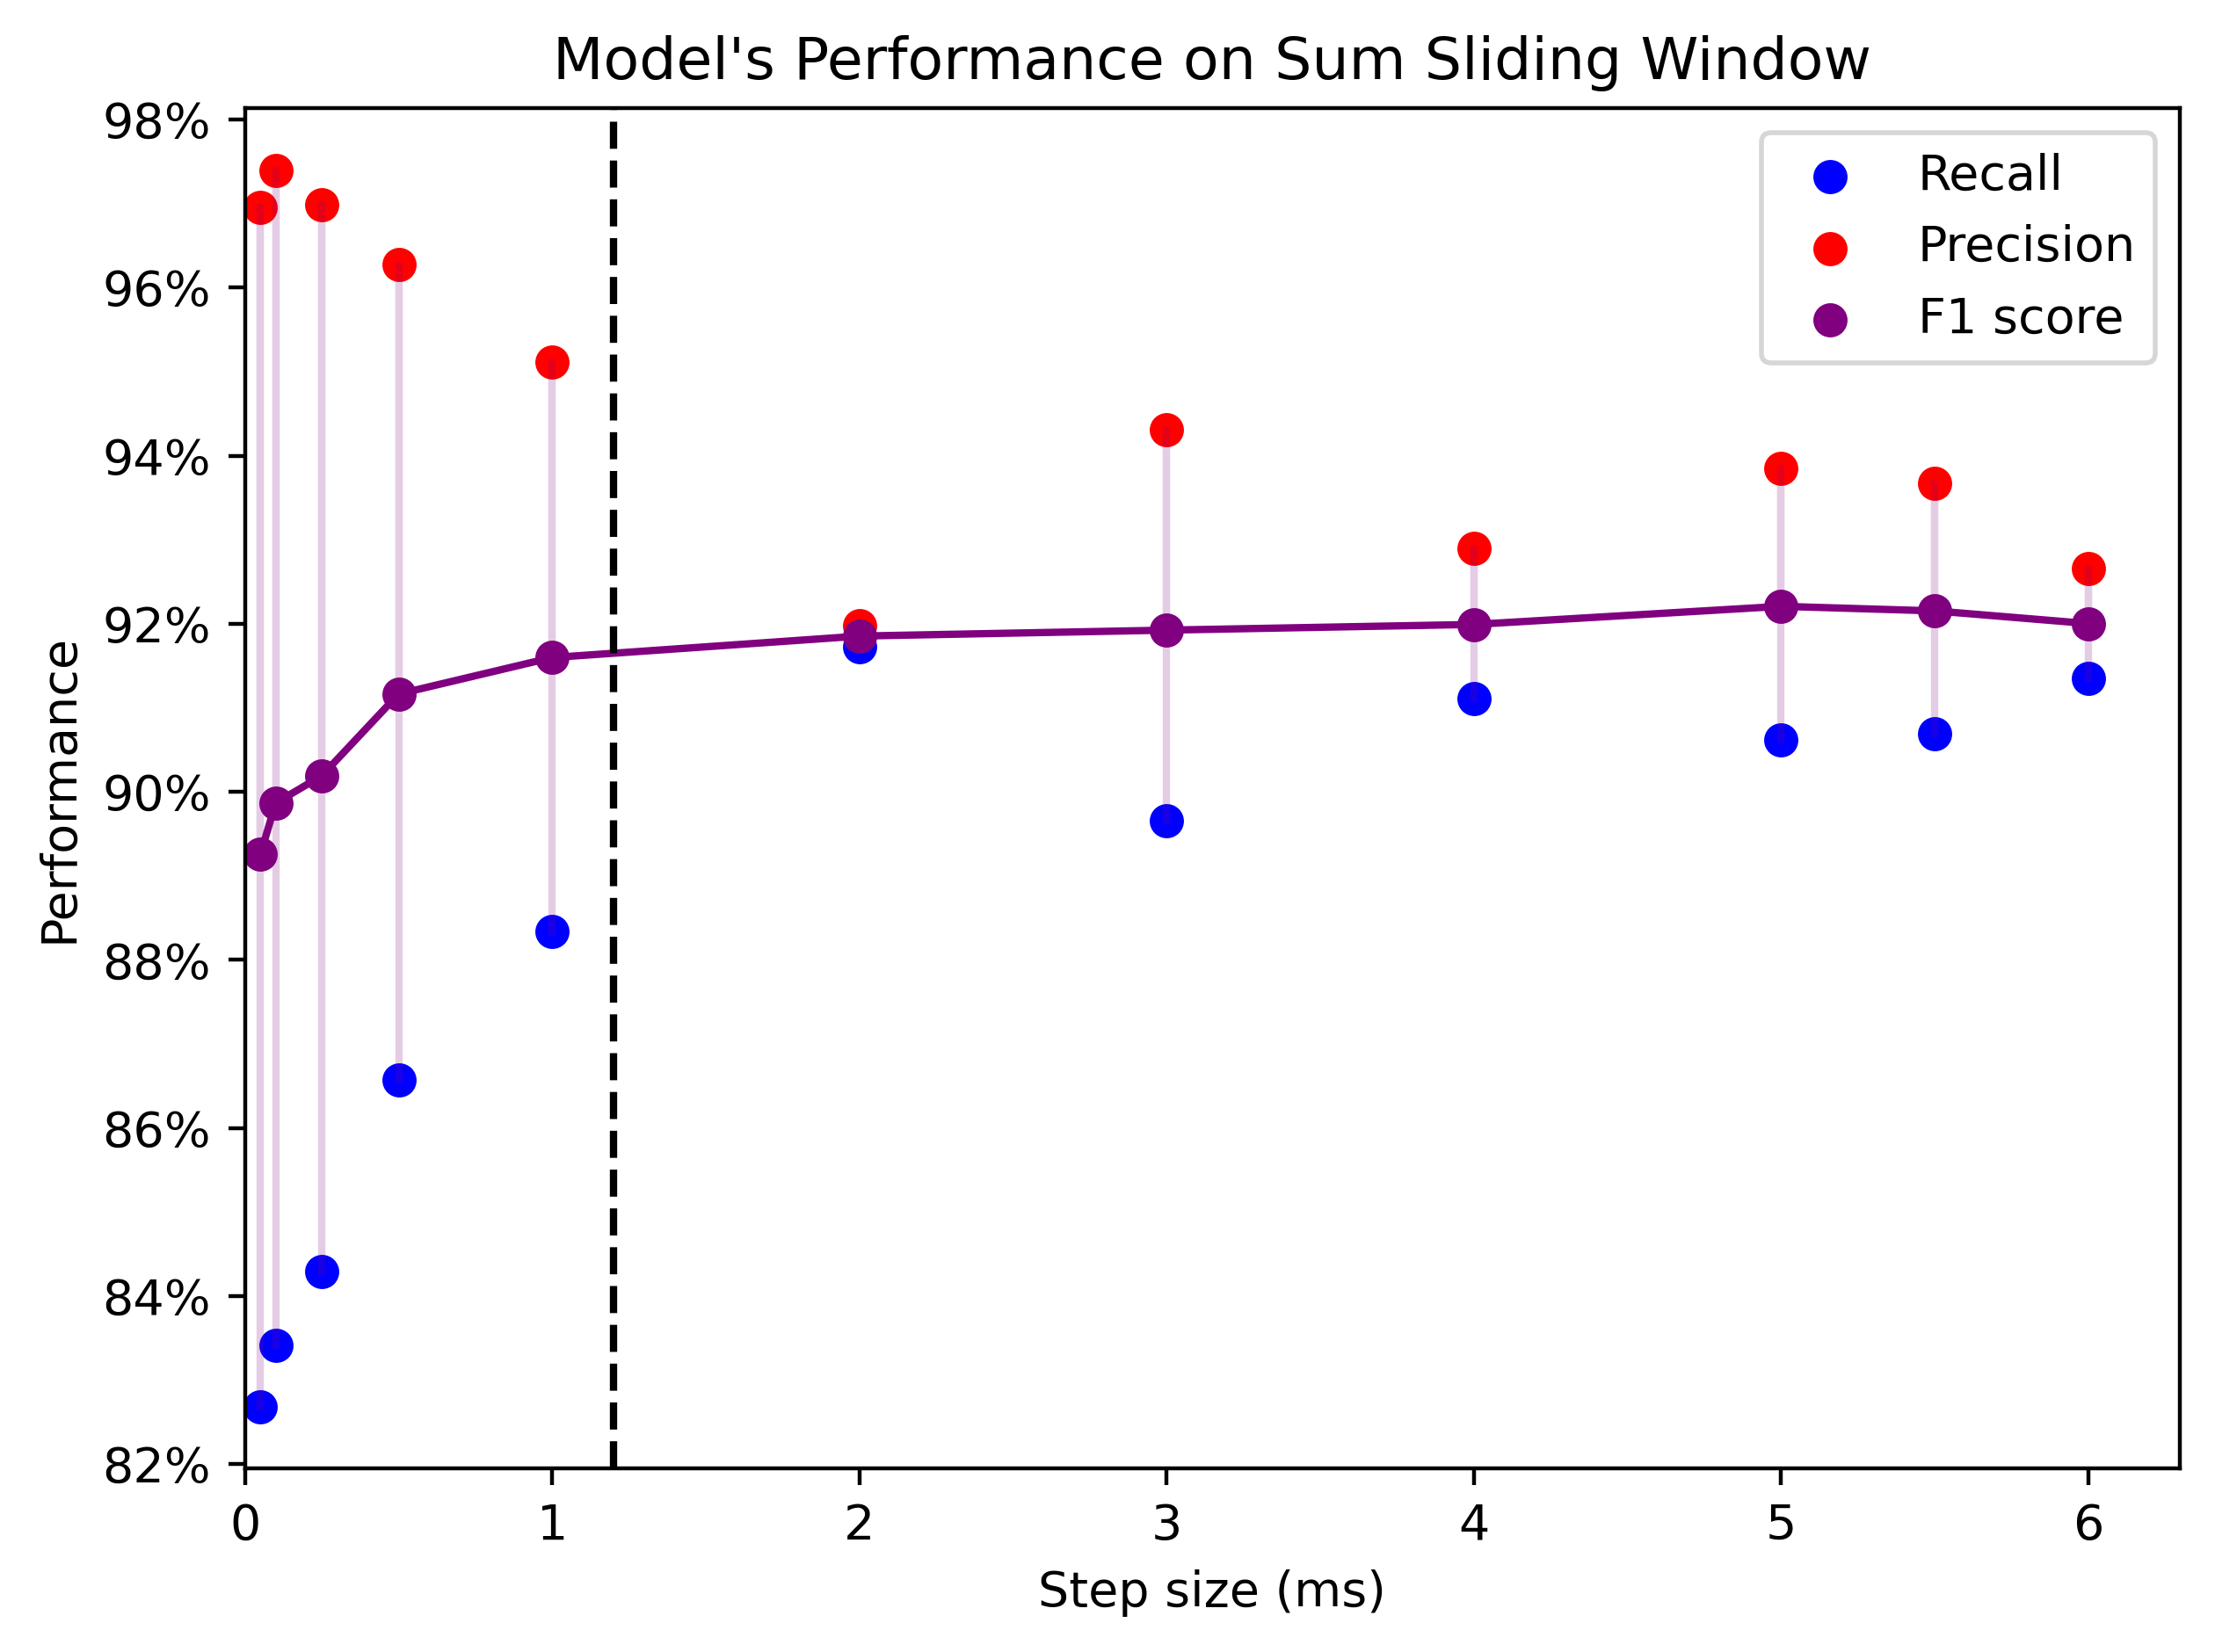

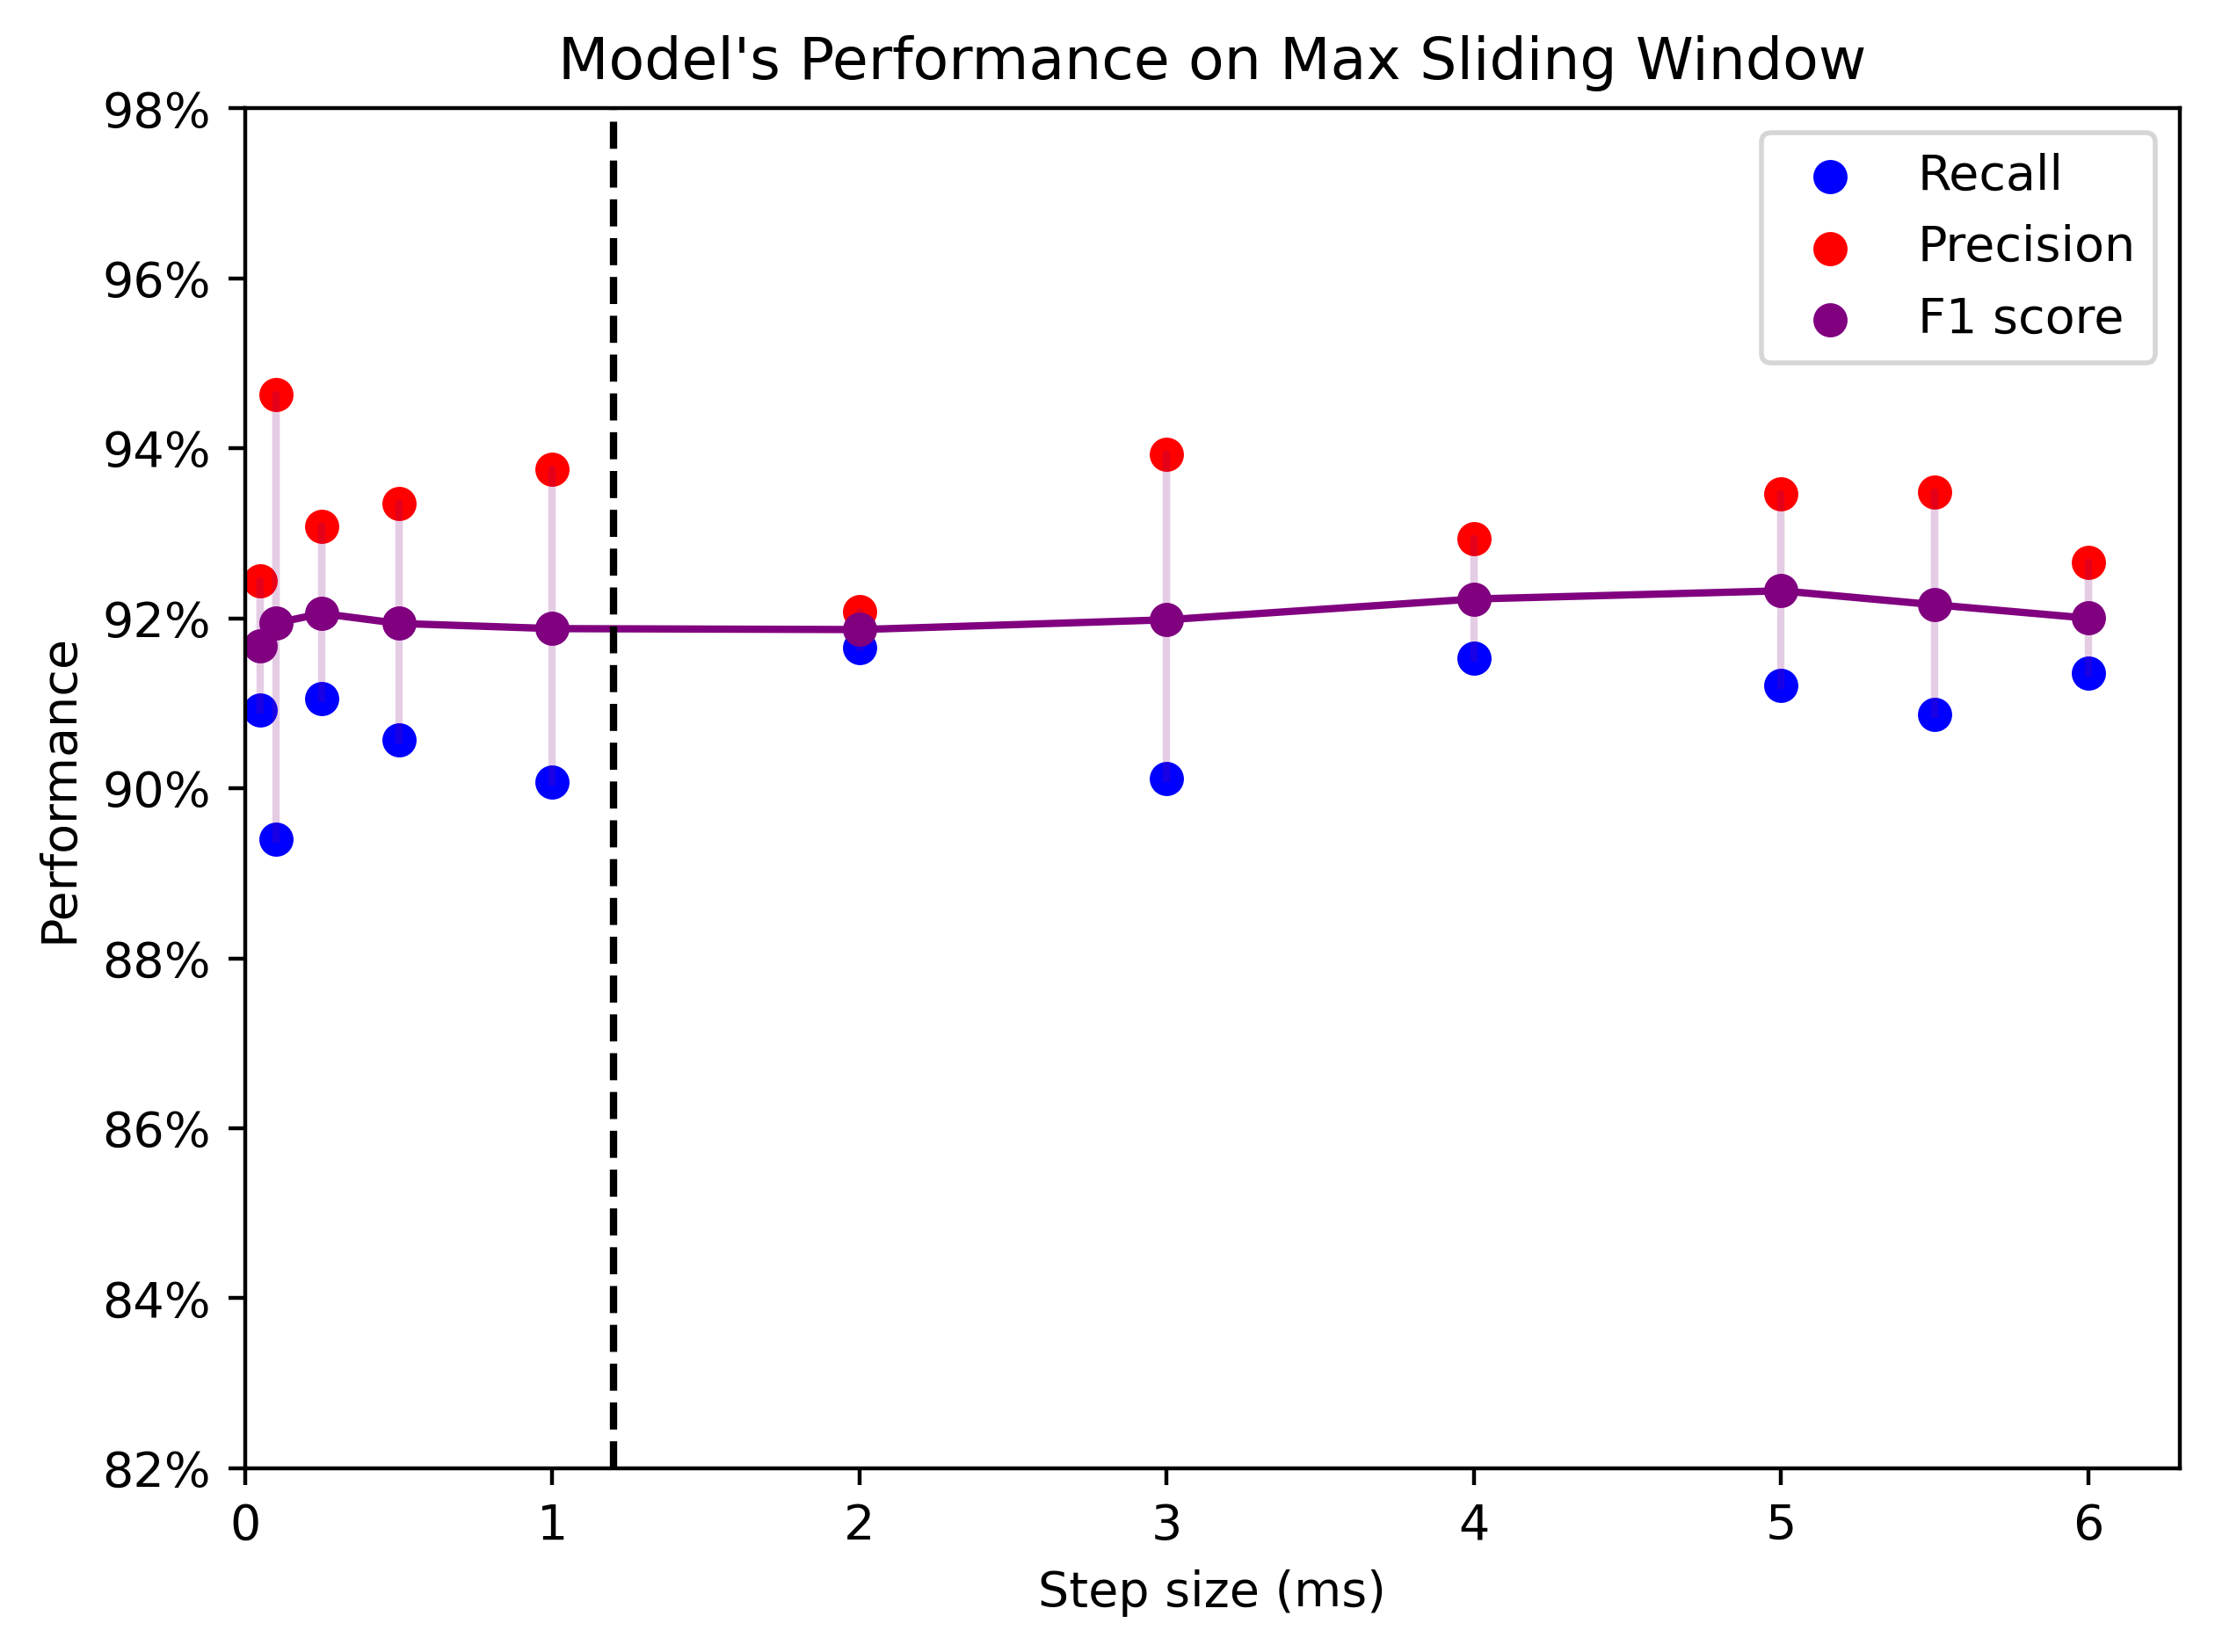

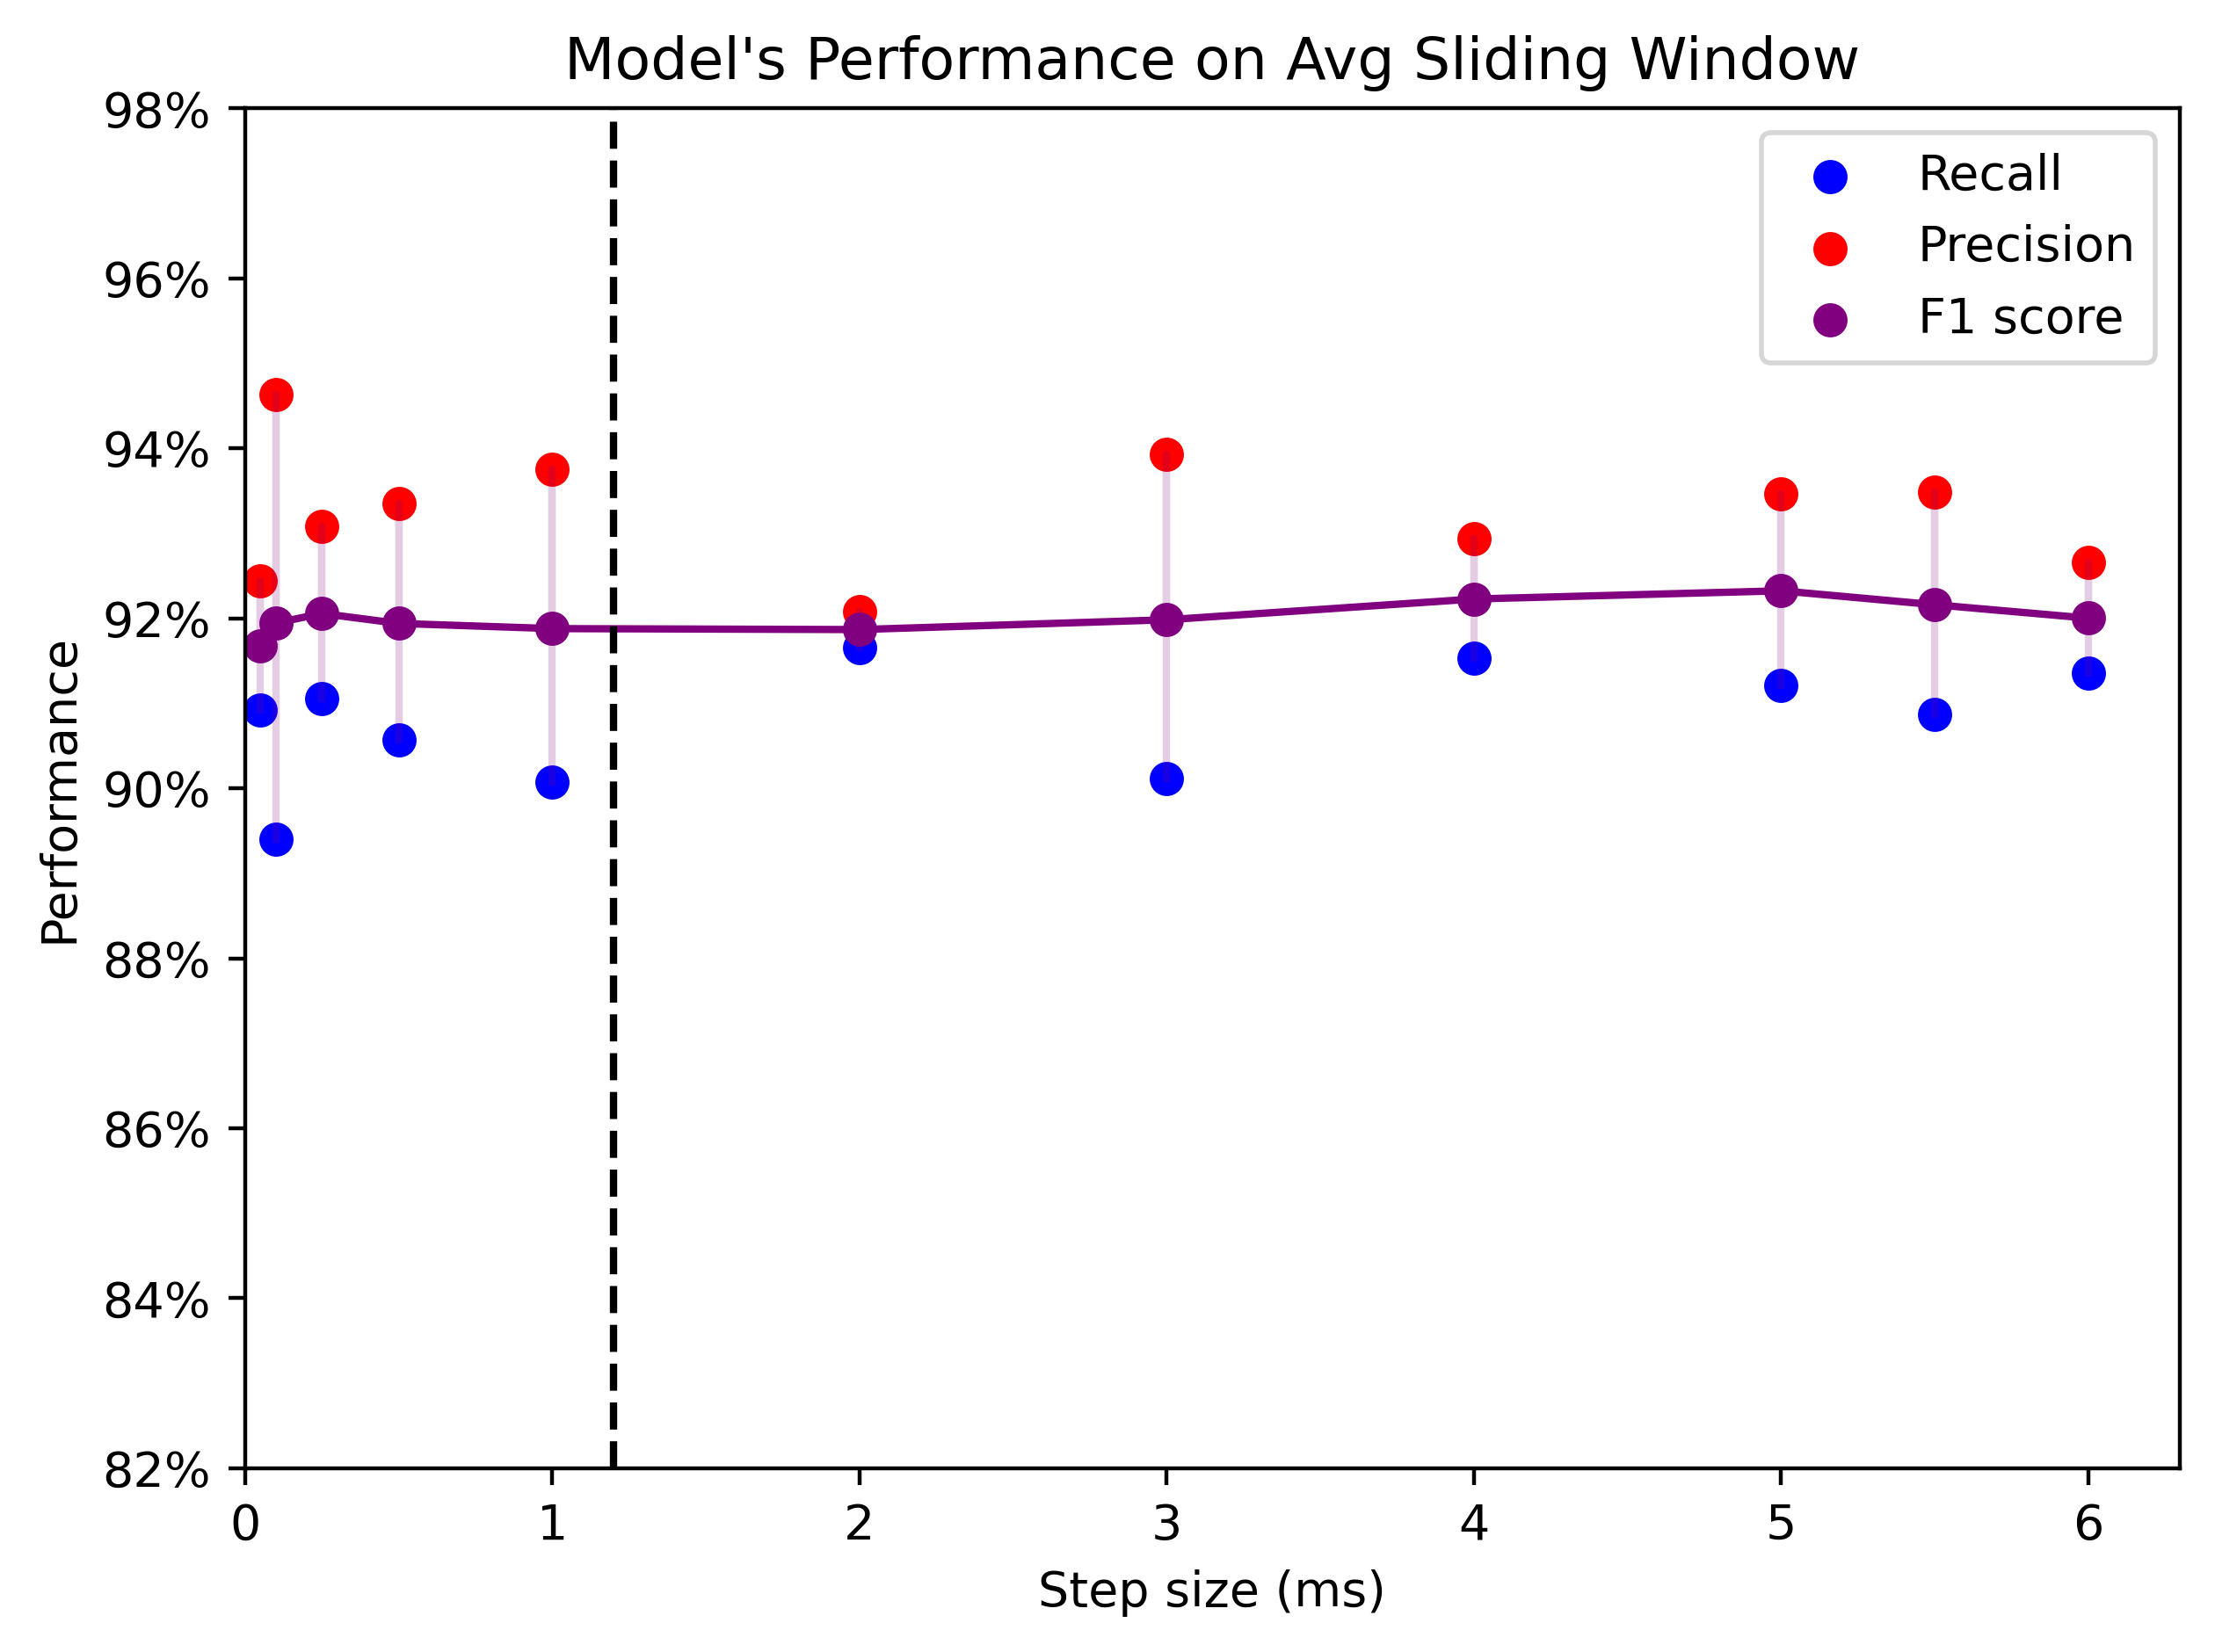

In [67]:
set_dpi(400)
##
# Plot data
plots = ((stride_to_perf_summed, "Model's Performance on Sum Sliding Window"),
         (stride_to_perf_maxed, "Model's Performance on Max Sliding Window"),
         (stride_to_perf_avged, "Model's Performance on Avg Sliding Window"))
for stride_to_perf, title in plots:
    plt.title(title)
    plt.xlabel("Step size (ms)")
    plt.ylabel("Performance")

    strides = []  # In ms
    f1_scores = []
    for i, (stride, (recall, precision, f1)) in enumerate(stride_to_perf.items()):
        stride /= 20  # samples to ms

        # Plot points
        plt.scatter(stride, recall, c="blue", label="Recall" if i==0 else None)
        plt.scatter(stride, precision, c="red", label="Precision" if i==0 else None)
        plt.scatter(stride, f1, c="purple", label="F1 score" if i==0 else None)

        # Plot vertical line to connect points
        plt.plot([stride]*3, [recall, precision, f1], c="purple", alpha=0.2)

        # Store for line
        strides.append(stride)
        f1_scores.append(f1)
    # Plot line
    plt.plot(strides, f1_scores, c="purple")

    yticks = range(82, 98+1, 2)
    plt.yticks(yticks, [str(y)+"%" for y in yticks])

    plt.axvline(1.199, color="black", linestyle="dashed")

    plt.xlim(0)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [80]:
IDX = 10
avged = outputs_avged_list[IDX][0, :]
maxed = outputs_maxed_list[IDX][0, :]

In [81]:
torch.all(torch.isclose(avged, maxed))

tensor(True)

In [82]:
torch.all(avged == maxed)

tensor(True)